# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

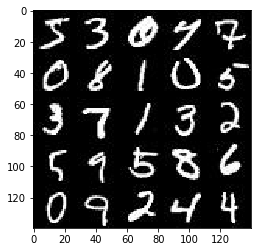

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

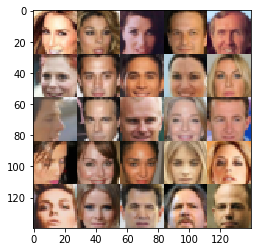

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

In [4]:
mnist_images[-1]

array([[[ 120.,  115.,   83.],
        [ 121.,  116.,   84.],
        [ 120.,  115.,   83.],
        ..., 
        [  60.,   48.,   28.],
        [  76.,   73.,   54.],
        [  89.,   88.,   64.]],

       [[ 121.,  116.,   84.],
        [ 121.,  116.,   84.],
        [ 121.,  116.,   84.],
        ..., 
        [  59.,   43.,   27.],
        [  56.,   51.,   36.],
        [  82.,   82.,   58.]],

       [[ 122.,  118.,   84.],
        [ 122.,  118.,   84.],
        [ 120.,  116.,   82.],
        ..., 
        [  58.,   43.,   27.],
        [  39.,   33.,   20.],
        [  60.,   58.,   36.]],

       ..., 
       [[ 147.,  137.,   99.],
        [ 146.,  137.,   99.],
        [ 145.,  136.,   98.],
        ..., 
        [  97.,   71.,   37.],
        [ 107.,   76.,   40.],
        [ 118.,  100.,   63.]],

       [[ 142.,  133.,   93.],
        [ 140.,  131.,   91.],
        [ 141.,  132.,   92.],
        ..., 
        [  94.,   69.,   37.],
        [ 106.,   78.,   44.],
        [ 

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real= tf.placeholder(tf.float32,[None,image_width,image_height,image_channels],name='input_real')
    input_z = tf.placeholder(tf.float32,[None,z_dim],name='input_z')
    lr = tf.placeholder(tf.float32,name='learning_rate')
    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [15]:
def discriminator(images, reuse=False,alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
#     print(images)
    with tf.variable_scope('discriminator',reuse=reuse):
        '''
        orig_shape = images.get_shape().as_list()
        layer = tf.reshape(images, shape=[-1, orig_shape[1] * orig_shape[2] * orig_shape[3]])
        layer = tf.layers.dense(layer, 1, activation=tf.nn.relu)
        logits = tf.layers.dense(layer,1)
        '''
        #28*28*1
        kersize = 5
        keepprob = .6
        startDim= 128
        x1 = tf.layers.conv2d(images,startDim,(kersize,kersize),strides = 2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn1 = tf.layers.batch_normalization(x1,training=True)
        relu1 = tf.maximum(alpha *bn1,bn1)
#         relu1 = tf.nn.dropout(relu1,keep_prob = keepprob)
        
        #14*14*64  
        x2 = tf.layers.conv2d(relu1,startDim*2,(kersize,kersize),padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2,training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
#         relu2 = tf.nn.dropout(relu2,keep_prob = keepprob)
       
        
        x1 = tf.layers.conv2d(relu2,startDim*4,(kersize,kersize),padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn1 = tf.layers.batch_normalization(x1,training=True)
        relu1 = tf.maximum(alpha *bn1,bn1)
#         relu1 = tf.nn.dropout(relu1,keep_prob = keepprob)
        
         
        x1 = tf.layers.max_pooling2d(relu1,(2,2),(2,2),padding='same')
        bn1 = tf.layers.batch_normalization(x1,training=True)
        relu1 = tf.maximum(alpha * bn1, bn1)
#         relu1 = tf.nn.dropout(relu1,keep_prob = keepprob)
        #7 * 7 *128
        #7 * 7 *128
        flat = tf.reshape(relu1,(-1, 7*7*startDim*8))
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [8]:
def generator(z, out_channel_dim,is_train=True,alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
#     print(z,out_channel_dim,is_train)
#     is_train = reuse
    with tf.variable_scope('generator',reuse=not is_train):
        startDim= 512
        keepprob = .6
        kersize = 5
        fullconn = tf.layers.dense(z,7*7*startDim*4,activation=None)
        
        x1 = tf.reshape(fullconn,[-1,7,7,startDim*4])
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1,x1)
        x1 = tf.nn.dropout(x1,keep_prob = keepprob)

#         x2 = tf.layers.conv2d_transpose(x1,startDim*8,kersize,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
#         x2 = tf.layers.batch_normalization(x2, training=is_train)
#         x2 = tf.maximum(alpha*x2,x2)
#         x2 = tf.nn.dropout(x2,keep_prob = keepprob)
        
        
        x2 = tf.layers.conv2d_transpose(x1,startDim*2,(kersize,kersize),strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2,x2)
        x2 = tf.nn.dropout(x2,keep_prob = keepprob)
        
        x2 = tf.layers.conv2d_transpose(x2,startDim,(kersize,kersize),strides = 2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2,x2)
        x2 = tf.nn.dropout(x2,keep_prob = keepprob)
  
        x2 = tf.layers.conv2d_transpose(x2,int(startDim/2),(kersize,kersize),padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2,x2)
        x2 = tf.nn.dropout(x2,keep_prob = keepprob)
        
        x2 = tf.layers.conv2d_transpose(x2,int(startDim/4),(kersize,kersize),padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2,x2)
        x2 = tf.nn.dropout(x2,keep_prob = keepprob)
        
        logits = tf.layers.conv2d_transpose(x2,out_channel_dim,(kersize,kersize),padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.tanh(logits)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim,alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim,True,alpha)

    d_model_real, d_logits_real = discriminator(input_real, False,alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, True,alpha)

    smooth = 0.1
    # Calculate losses
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real, 
                                                          labels = tf.ones_like(d_logits_real) * (1 - smooth)))

    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, 
                                                          labels = tf.zeros_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, 
                                                          labels = tf.ones_like(d_logits_fake)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get the trainable_variables, split into G and D parts
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    # print(g_vars)

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss,var_list = d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss,var_list = g_vars)
        
        

#     d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss,var_list = d_vars)
#     with tf.control_dependencies([d_train_opt]):
#         g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss,var_list = g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, 
          data_shape, data_image_mode,alpha):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
#     tf.reset_default_graph()
    # TODO: Build Model
#     print(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode)
    epoches = 0
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
#     print('start....')
    d_loss, g_loss = model_loss(input_real, input_z,  data_shape[3],alpha)
#     print('start....1111')
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
#     print('start....')
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    with tf.Session(config=config) as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                 # Sample random noise for G
#                 print(batch_images)
                batch_images = batch_images * 2
#                 print('batch_images',batch_images)
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
#                 print('batch_z',batch_z)
                # Run optimizers
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z,input_real: batch_images})
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
#               _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})

                if epoches % 100 == 0:
                    show_generator_output(sess, 28, input_z, data_shape[3], data_image_mode)
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))
#                     print('epoches',epoches)
                epoches = epoches+1
            # At the end of each epoch, get the losses and print them out

            

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

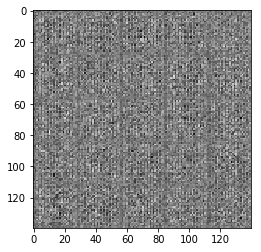

Epoch 1/2... Discriminator Loss: 1.4771... Generator Loss: 2.4558


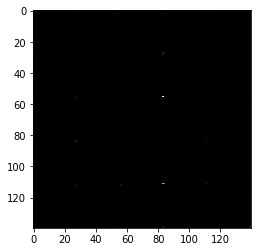

Epoch 1/2... Discriminator Loss: 0.7566... Generator Loss: 1.5447


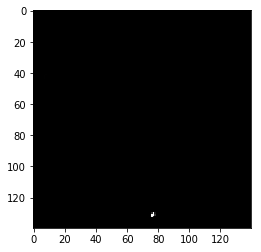

Epoch 1/2... Discriminator Loss: 0.6842... Generator Loss: 2.0470


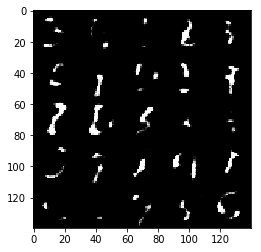

Epoch 1/2... Discriminator Loss: 1.1638... Generator Loss: 1.2450


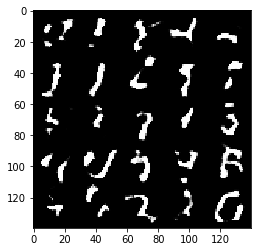

Epoch 1/2... Discriminator Loss: 0.5894... Generator Loss: 1.8073


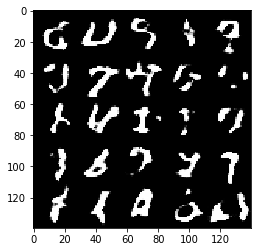

Epoch 1/2... Discriminator Loss: 0.9199... Generator Loss: 1.3391


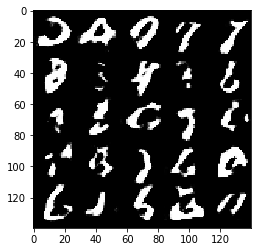

Epoch 1/2... Discriminator Loss: 1.0783... Generator Loss: 1.3582


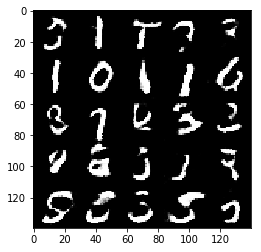

Epoch 1/2... Discriminator Loss: 0.6930... Generator Loss: 1.7437


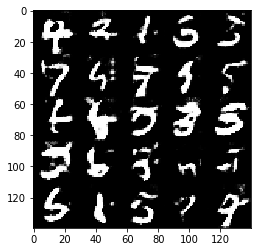

Epoch 1/2... Discriminator Loss: 0.6241... Generator Loss: 1.9984


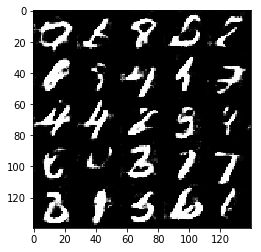

Epoch 1/2... Discriminator Loss: 0.9323... Generator Loss: 1.1189


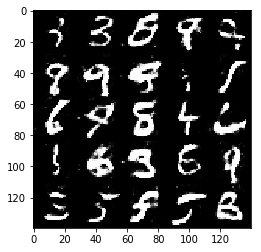

Epoch 2/2... Discriminator Loss: 0.6981... Generator Loss: 2.0241


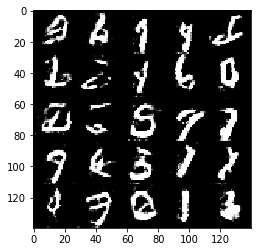

Epoch 2/2... Discriminator Loss: 1.4618... Generator Loss: 0.7630


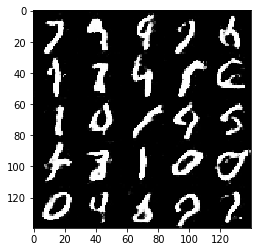

Epoch 2/2... Discriminator Loss: 0.9627... Generator Loss: 1.1591


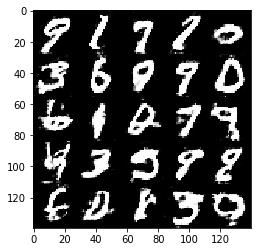

Epoch 2/2... Discriminator Loss: 1.1870... Generator Loss: 1.0963


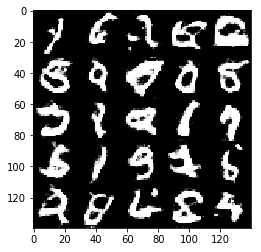

Epoch 2/2... Discriminator Loss: 2.6272... Generator Loss: 0.2212


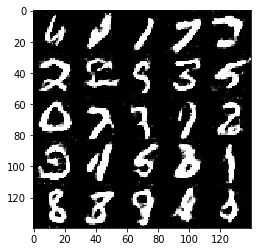

Epoch 2/2... Discriminator Loss: 0.5525... Generator Loss: 2.3044


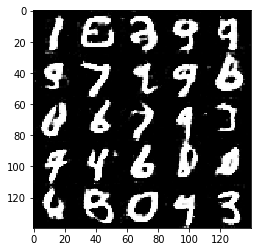

Epoch 2/2... Discriminator Loss: 0.7852... Generator Loss: 1.2205


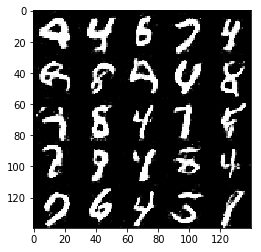

Epoch 2/2... Discriminator Loss: 1.1328... Generator Loss: 4.0055


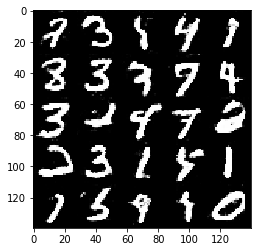

Epoch 2/2... Discriminator Loss: 2.3757... Generator Loss: 0.3093


In [17]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = .4
alpha = 0.01


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode,alpha)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

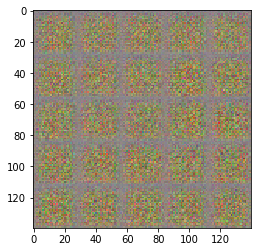

Epoch 1/1... Discriminator Loss: 4.3510... Generator Loss: 38.9674


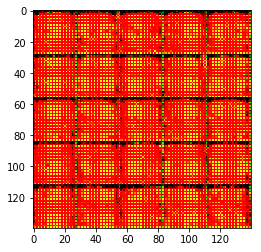

Epoch 1/1... Discriminator Loss: 1.0703... Generator Loss: 13.2387


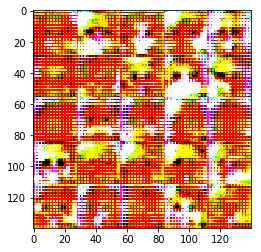

Epoch 1/1... Discriminator Loss: 0.6114... Generator Loss: 18.6330


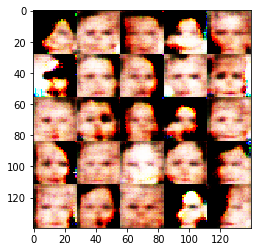

Epoch 1/1... Discriminator Loss: 4.2876... Generator Loss: 10.9008


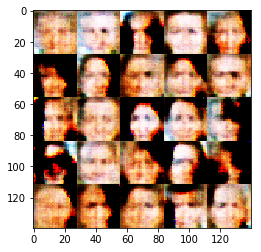

Epoch 1/1... Discriminator Loss: 0.7871... Generator Loss: 7.3350


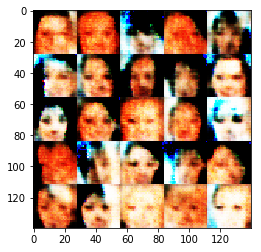

Epoch 1/1... Discriminator Loss: 1.1478... Generator Loss: 2.4407


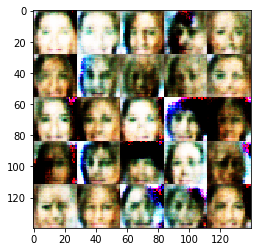

Epoch 1/1... Discriminator Loss: 0.6645... Generator Loss: 8.2870


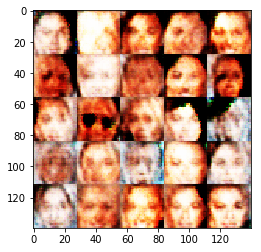

Epoch 1/1... Discriminator Loss: 0.5205... Generator Loss: 3.1785


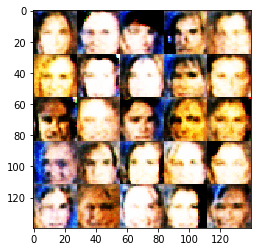

Epoch 1/1... Discriminator Loss: 3.3431... Generator Loss: 9.1394


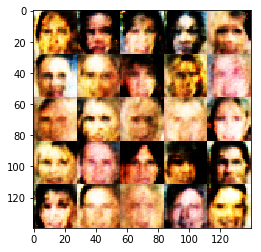

Epoch 1/1... Discriminator Loss: 0.6328... Generator Loss: 4.0845


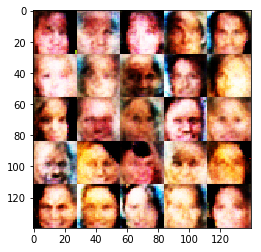

Epoch 1/1... Discriminator Loss: 0.8041... Generator Loss: 4.9692


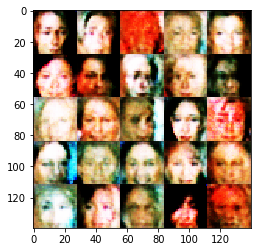

Epoch 1/1... Discriminator Loss: 0.8075... Generator Loss: 2.0348


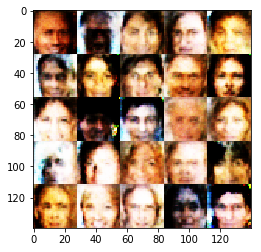

Epoch 1/1... Discriminator Loss: 2.4688... Generator Loss: 6.9347


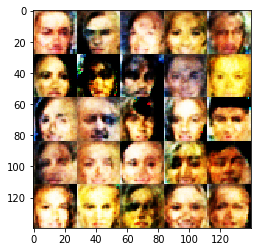

Epoch 1/1... Discriminator Loss: 2.6616... Generator Loss: 6.9439


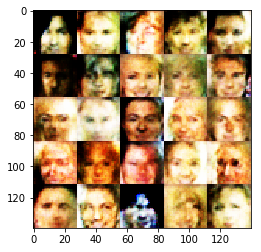

Epoch 1/1... Discriminator Loss: 1.1326... Generator Loss: 0.9070


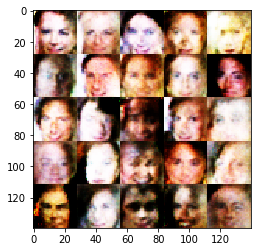

Epoch 1/1... Discriminator Loss: 0.9944... Generator Loss: 1.0024


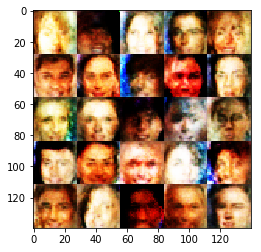

Epoch 1/1... Discriminator Loss: 0.5782... Generator Loss: 2.3086


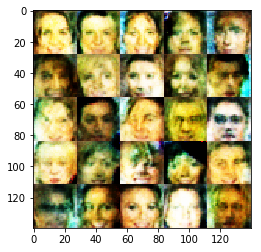

Epoch 1/1... Discriminator Loss: 0.6715... Generator Loss: 1.7544


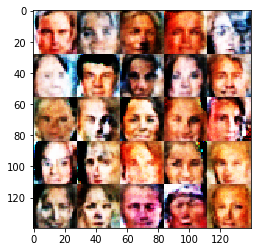

Epoch 1/1... Discriminator Loss: 0.9225... Generator Loss: 1.2230


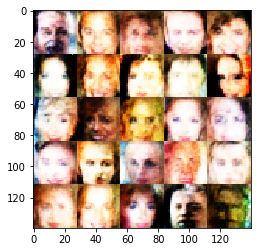

Epoch 1/1... Discriminator Loss: 0.9437... Generator Loss: 0.9362


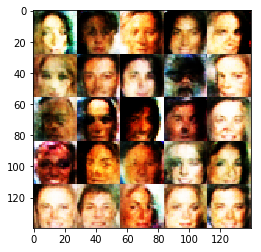

Epoch 1/1... Discriminator Loss: 0.6178... Generator Loss: 2.2774


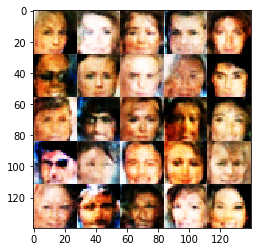

Epoch 1/1... Discriminator Loss: 0.7264... Generator Loss: 2.3723


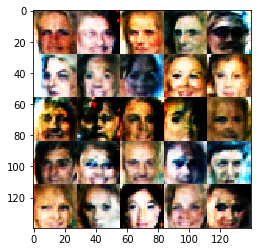

Epoch 1/1... Discriminator Loss: 0.7382... Generator Loss: 2.9554


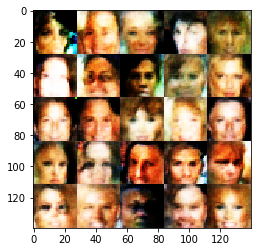

Epoch 1/1... Discriminator Loss: 0.6746... Generator Loss: 1.5923


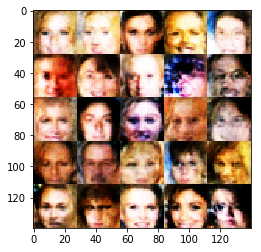

Epoch 1/1... Discriminator Loss: 0.5905... Generator Loss: 2.0503


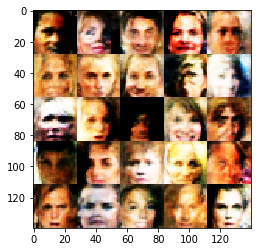

Epoch 1/1... Discriminator Loss: 0.7863... Generator Loss: 3.1718


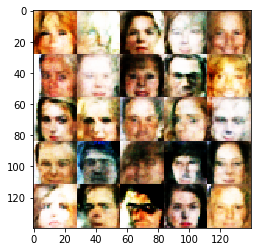

Epoch 1/1... Discriminator Loss: 0.7186... Generator Loss: 2.0517


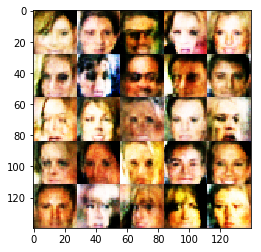

Epoch 1/1... Discriminator Loss: 0.8765... Generator Loss: 1.0712


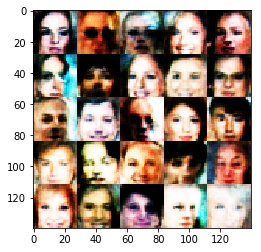

Epoch 1/1... Discriminator Loss: 0.7772... Generator Loss: 1.7857


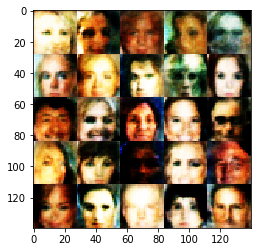

Epoch 1/1... Discriminator Loss: 0.7960... Generator Loss: 1.9002


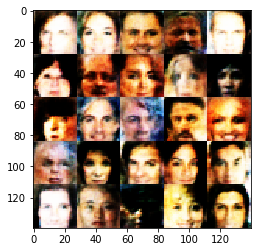

Epoch 1/1... Discriminator Loss: 0.7468... Generator Loss: 1.6094


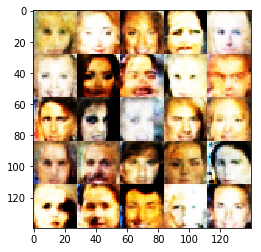

Epoch 1/1... Discriminator Loss: 1.0535... Generator Loss: 0.7770


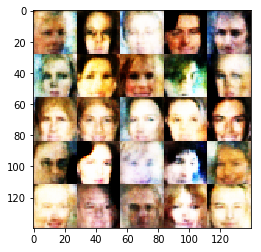

Epoch 1/1... Discriminator Loss: 0.7746... Generator Loss: 1.9541


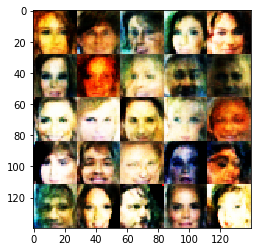

Epoch 1/1... Discriminator Loss: 0.7558... Generator Loss: 2.3135


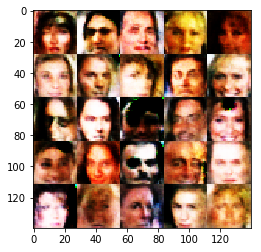

Epoch 1/1... Discriminator Loss: 1.2166... Generator Loss: 2.5507


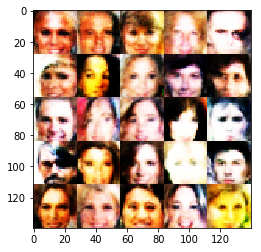

Epoch 1/1... Discriminator Loss: 1.1952... Generator Loss: 2.9114


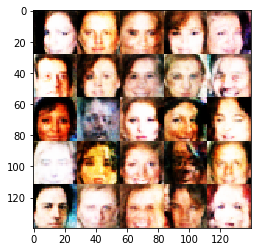

Epoch 1/1... Discriminator Loss: 0.8476... Generator Loss: 1.6930


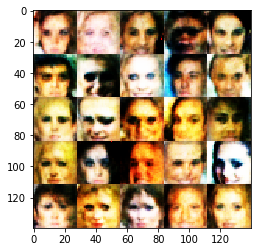

Epoch 1/1... Discriminator Loss: 0.8971... Generator Loss: 0.9701


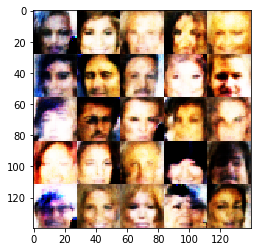

Epoch 1/1... Discriminator Loss: 0.8185... Generator Loss: 1.3267


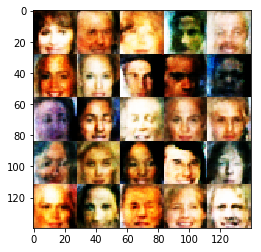

Epoch 1/1... Discriminator Loss: 0.8286... Generator Loss: 1.4167


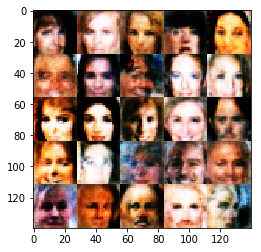

Epoch 1/1... Discriminator Loss: 1.0050... Generator Loss: 1.7098


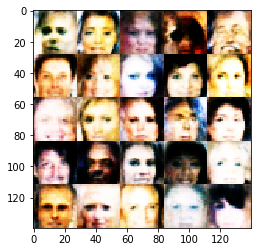

Epoch 1/1... Discriminator Loss: 0.8215... Generator Loss: 1.6145


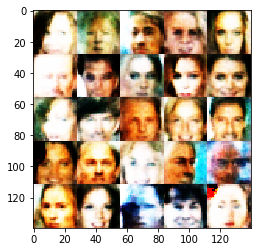

Epoch 1/1... Discriminator Loss: 0.8756... Generator Loss: 1.5629


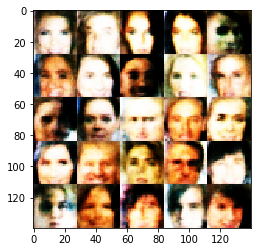

Epoch 1/1... Discriminator Loss: 1.0233... Generator Loss: 1.6662


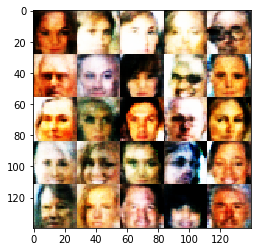

Epoch 1/1... Discriminator Loss: 1.1490... Generator Loss: 0.7538


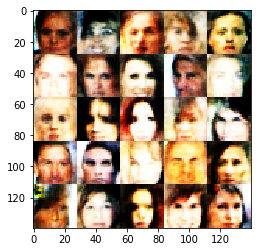

Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 2.2066


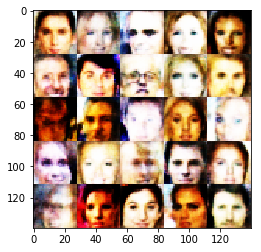

Epoch 1/1... Discriminator Loss: 0.8595... Generator Loss: 1.2317


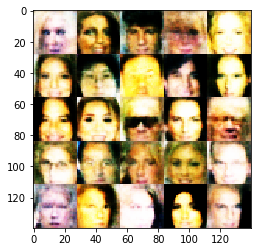

Epoch 1/1... Discriminator Loss: 0.9828... Generator Loss: 0.9645


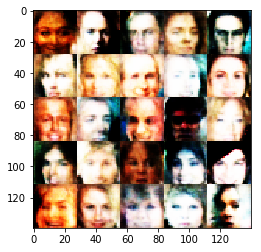

Epoch 1/1... Discriminator Loss: 0.9201... Generator Loss: 1.1792


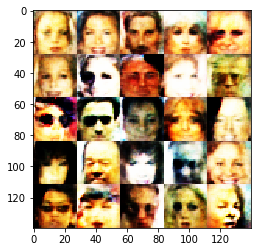

Epoch 1/1... Discriminator Loss: 0.8425... Generator Loss: 1.7690


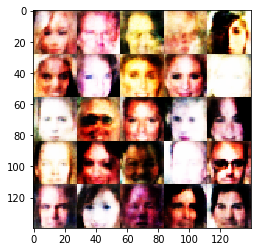

Epoch 1/1... Discriminator Loss: 1.0693... Generator Loss: 0.7989


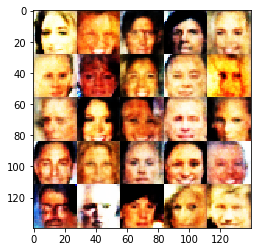

Epoch 1/1... Discriminator Loss: 1.0013... Generator Loss: 1.0957


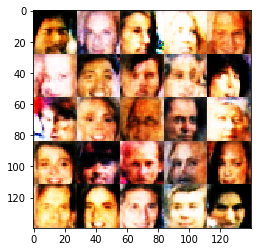

Epoch 1/1... Discriminator Loss: 0.9750... Generator Loss: 0.9472


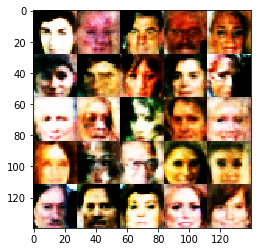

Epoch 1/1... Discriminator Loss: 0.9532... Generator Loss: 1.0489


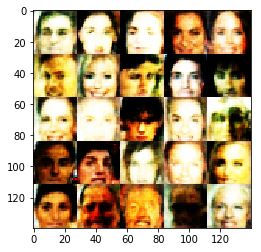

Epoch 1/1... Discriminator Loss: 0.9787... Generator Loss: 1.2303


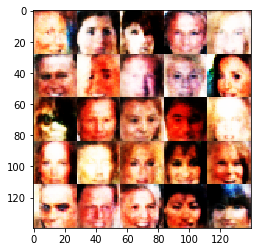

Epoch 1/1... Discriminator Loss: 0.9713... Generator Loss: 1.7125


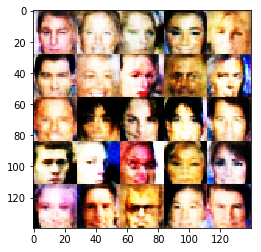

Epoch 1/1... Discriminator Loss: 0.9434... Generator Loss: 1.5901


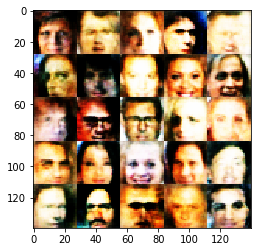

Epoch 1/1... Discriminator Loss: 0.8690... Generator Loss: 1.4685


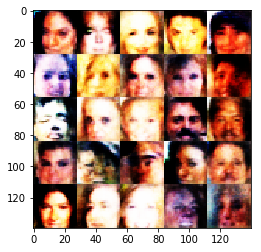

Epoch 1/1... Discriminator Loss: 0.8574... Generator Loss: 1.2405


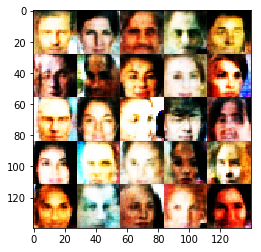

Epoch 1/1... Discriminator Loss: 0.9048... Generator Loss: 1.1035


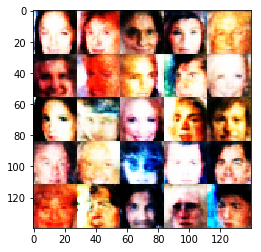

Epoch 1/1... Discriminator Loss: 0.8945... Generator Loss: 1.5052


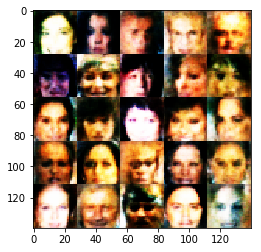

Epoch 1/1... Discriminator Loss: 0.9184... Generator Loss: 1.0985


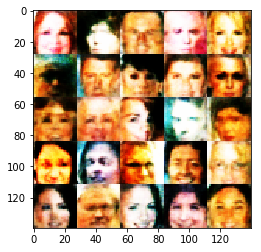

Epoch 1/1... Discriminator Loss: 1.0087... Generator Loss: 1.0302


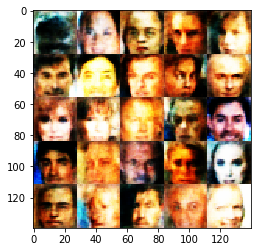

Epoch 1/1... Discriminator Loss: 1.1521... Generator Loss: 0.7193


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5
alpha = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode,alpha)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。